In [346]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import findatree.io as io

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define raster-files and print infos

In [44]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Repos\findatree\example-data\DSM_2021'])
dir_names.extend([r'C:\Repos\findatree\example-data\DTM'])
dir_names.extend([r'C:\Repos\findatree\example-data\Orthophotos_2021'])

file_names=[]
file_names.extend(['Tnr_11626_D-20210719_DSM.tif'])
file_names.extend(['tnr_11626_dtm.tif'])
file_names.extend(['Tnr_11626_2021_Ortho.tif'])


paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

io.print_raster_info(paths)


(0)
Name: C:/Repos/findatree/example-data/DSM_2021/Tnr_11626_D-20210719_DSM.tif
Width[px]: 5749
Height[px]: 5423
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-32767.0,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=742322.8121385165, bottom=5457550.352693843, right=742825.1654599565, top=5458024.21981198)
Affine geo-transfrom: [0.087380991727266, 0.0, 742322.8121385165, 0.0, -0.08738099172726485, 5458024.21981198]

(1)
Name: C:/Repos/findatree/example-data/DTM/tnr_11626_dtm.tif
Width[px]: 461
Height[px]: 425
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-3.4028234663852886e+38,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=742354.9683434721, bottom=5457599.985097144, right=742815.9683434721, top=5458024.985097144)
Affine geo-transfrom: [1.0, 0.0, 742354.9683434721, 0.0, -1.0, 5458024.985097144]

(2)
Name: C:/Repos/findatree/example-data/Orthophotos_2021/Tnr_11626_2021_Ortho.tif
Width[px]: 8236
Heig

### Reproject raster-files to same area & resolution

In [45]:
importlib.reload(io)
res = 0.25
bands, mask, A, bound = io.reproject_all_intersect(paths, res=res)

### Pre-select area by CHM and NDVI
I.e. all px with CHM > ``h_crit`` and NDVI > ``ndvi_crit``. 

(1000.0, 400.0)

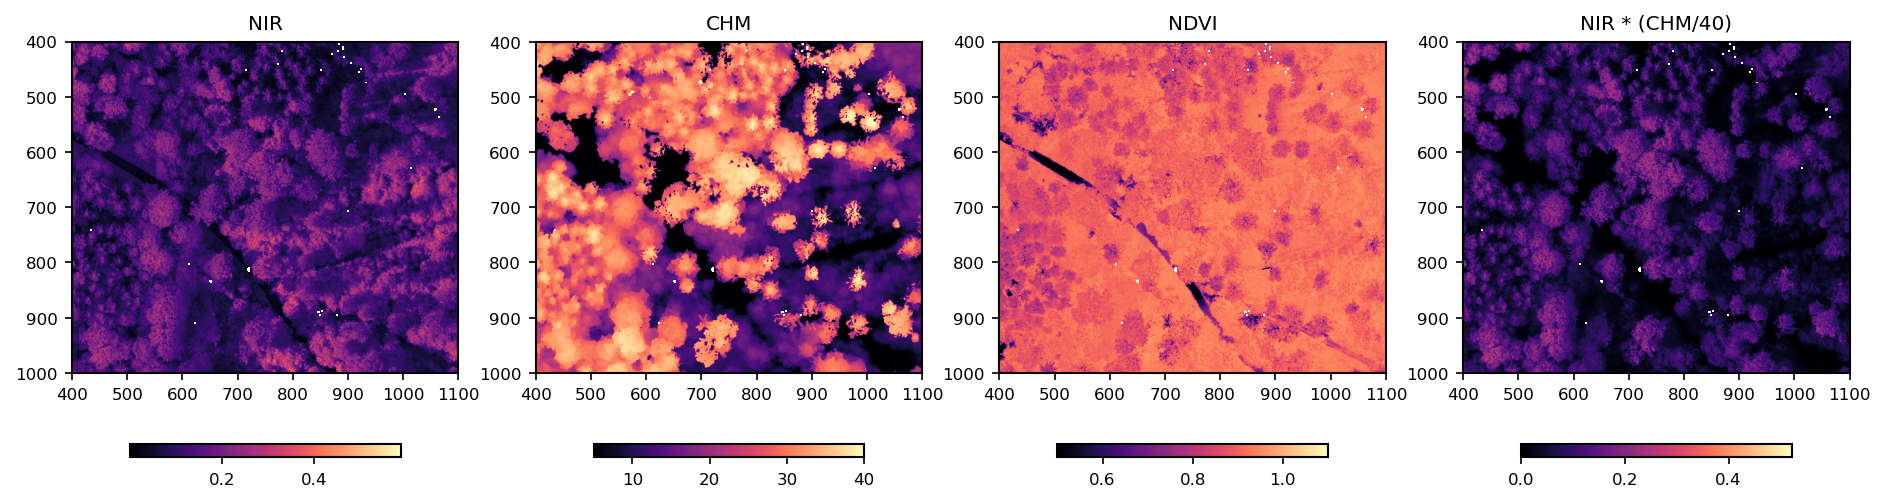

In [226]:
import cv2 as cv

xlim = (400, 1100)
ylim = (1000, 400)
# xlim = (0, bands[0].shape[1])
# ylim = (bands[0].shape[0], 0)

chm = (bands[0][:,:,0] - bands[1][:,:,0]).astype(np.float32)
red = (bands[2][:,:,2] / (2**16 - 1)).astype(np.float32)
green = (bands[2][:,:,1] / (2**16 - 1)).astype(np.float32)
nir = (bands[2][:,:,4] / (2**16 - 1)).astype(np.float32)

ndvi = (nir - red) / (nir + red)
gr = (green - red) / (green + red)


########### Plotting
f, axs = plt.subplots(ncols=4, figsize=(15,4))
f.subplots_adjust(hspace=0.01)


##############################################
img = nir

ax = axs[0]
mapp = ax.imshow(
    img,
    vmin=np.nanmin(img.flatten()),
    vmax=np.nanmax(img.flatten()),
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('NIR')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

##############################################
img = chm.copy()
ax = axs[1]
mapp = ax.imshow(
    img,
    vmin=5,
    vmax=40,
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('CHM')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

##############################################
img = ndvi

ax = axs[2]
mapp = ax.imshow(
    img,
    vmin=0.5,
    vmax=1.1,
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('NDVI')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

##############################################
img = nir * (chm / 40)

ax = axs[3]
mapp = ax.imshow(
    img,
    vmin=0,
    vmax=np.nanmax(img.flatten()),
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('NIR * (CHM/40)')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [224]:
##################### Define image used for object detection
img_obj = nir * (chm/40)
img_obj[chm < 5] = np.nan
img_obj[ndvi < 0.5] = np.nan
img_obj -= np.nanmin(img_obj.flatten())
img_obj *= 255 / np.nanmax(img_obj.flatten())
img_obj = img_obj.astype(np.uint8)

##################### Median Blur
img_blur = cv.medianBlur(img_obj.astype(np.uint8), 3)
for i in range(10):
    img_blur = cv.medianBlur(img_blur.astype(np.uint8), 3)


##################### Gaussian adaptive thresholding
sure_bg = cv.adaptiveThreshold(img_blur, 1, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv.THRESH_BINARY, 241, 0)


##################### Divide connected regions into sub_regions
# Divide function
def divide_connected_regions(mask):
    # Get connected regions in mask  -> isles
    count, isles = cv.connectedComponents(mask.astype(np.uint8))
    isles_idx = [np.where(isles == i) for i in range(1, count)]

    # Distance trafo of mask
    dist_trafo = cv.distanceTransform(mask.astype(np.uint8), cv.DIST_L2, 5)

    # Initiate new mask
    new_mask = dist_trafo.astype(np.float32)
    
    # Go through isles and create sub-isles
    for idx in isles_idx:
        if len(idx[0]) >= 16:
            new_mask[idx] = new_mask[idx] - np.median(new_mask[idx])

    new_mask[new_mask <= 0] = 0
    new_mask[new_mask > 0] = 1

    return new_mask.astype(np.uint8)

# Divide
seed = sure_bg.copy()
for i in range(5):
    seed = divide_connected_regions(seed)


In [340]:
##################### Watershed
kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
seed_dilate = cv.dilate(seed, kernel, iterations=2)

ret, seed_mark= cv.connectedComponents(seed_dilate)

seed_mark[seed_mark > 0] = seed_mark[seed_mark > 0] + 1

kernel = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
sure_bg_dilate = cv.dilate(sure_bg, kernel, iterations=2)

markers = cv.bitwise_not(sure_bg_dilate * 255) / 255 + seed_mark

img = np.zeros((nir.shape[0], nir.shape[1], 3), dtype=np.uint8)
img[:,:,0] = img_blur
img[:,:,1] = img_blur
img[:,:,2] = img_blur

markers = cv.watershed(img, markers.astype(np.int32))

img[markers == -1] = 255

In [350]:

vals = np.linspace(0,1,256)
np.random.shuffle(vals)
vals[0] = 0
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))


f, axs = plt.subplots(ncols=5, figsize=(16, 4))
f.subplots_adjust(left=0.05, top=0.8, hspace=0.01)

############################################## 
ax = axs[0]
mapp = ax.imshow(
    img_obj,
    vmin=np.nanmin(img_obj.flatten()),
    vmax=np.nanmax(img_obj.flatten()),
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('NIR * (CHM/40)')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

############################################## 
ax = axs[1]
mapp = ax.imshow(
    img_blur,
    vmin=np.nanmin(img_blur.flatten()),
    vmax=np.nanmax(img_blur.flatten()),
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('Blurred')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

############################################## 
ax = axs[2]
mapp = ax.imshow(
    sure_bg_dilate * img_obj,
    # vmin=0,
    # vmax=1,
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('Thresholded')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

##############################################
ax = axs[3]
mapp = ax.imshow(
    sure_bg_dilate + seed,
    vmin=0,
    vmax=2,
    cmap='magma',
)
plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('Seed')
ax.set_xlim(xlim)
_ = ax.set_ylim(ylim)

##############################################
ax = axs[4]
mapp = ax.imshow(
    img[:,:,0],
    vmin=0,
    vmax=200,
    cmap='magma',
)

plt.colorbar(mapp, ax=ax, orientation='horizontal', shrink=0.7)
ax.set_title('Objects')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

f.savefig(r'C:\Repos\findatree\scripts\plots\objects.pdf', transparent=True)